# CSME2 Bonus Point Assignment 1

<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0, released 01/12/2021</div>
For detailed task instructions, please refer to the assignment PDF.

DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [1]:
# Add any additional import you need in this cellimport collections
import numpy as np
import scipy.io as scio
import collections
from sklearn.cluster import kmeans_plusplus
import matplotlib.pyplot as plt

np.random.seed(1234)

### Setup
__Task A.1__ Load the data into the following numpy arrays. For the output, only use the first torque variable.
Randomly split the data from the file ```sarcos_inv.mat``` into a training set (80%) and a validation set (20%).

In [2]:
# Input and output training data
data = scio.loadmat('sarcos_inv.mat')['sarcos_inv']
np.random.shuffle(data)
n = data.shape[0]
xs_train = data[:int(n*0.8),:21]
ys_train = data[:int(n*0.8),21].reshape(-1,1)
# Input and output validation data

xs_valid = data[int(n*0.8):,:21]
ys_valid = data[int(n*0.8):,21].reshape(-1,1)

# Input and output test data
data = scio.loadmat('sarcos_inv_test.mat')['sarcos_inv_test']
xs_test = data[:,:21]
ys_test = data[:,21].reshape(-1,1)

In [3]:
# Check for yourself 
# The following should lead to output 
# (44484, 21)
# (44484, 1)
# (8897, 21)
# (8897, 1)
# (4449, 21)
# (4449, 1)

print(xs_train.shape)
print(ys_train.shape)
print(xs_valid.shape)
print(ys_valid.shape)
print(xs_test.shape)
print(ys_test.shape)

(35587, 21)
(35587, 1)
(8897, 21)
(8897, 1)
(4449, 21)
(4449, 1)


__Task A.2__ Standardize the data such that
1. Training inputs have mean 0
2. Each training input variable has variance 1
3. The training outputs have mean 0
4. Apply the same transformation to the validation and test data

Implement this manually, i.e., do not use a ready scaler like the one provided by scikit-learn.

In [4]:
# Store the standardized data in the following variables
def standardized(data):
    means = data.mean(axis=0)
    stds = data.std(axis=0)
    return (data - means) / stds

xs_train_std = standardized(xs_train)
ys_train_std = standardized(ys_train)

xs_valid_std = standardized(xs_valid)
ys_valid_std = standardized(ys_valid)

xs_test_std = standardized(xs_test)
ys_test_std = standardized(ys_test)

In [5]:
# Check for yourself
# The following should lead to (roughly) six zeros and three arrays with (approximately) ones
print(np.mean(xs_train_std))
print(np.mean(ys_train_std))
print(np.mean(xs_valid_std))
print(np.mean(ys_valid_std))
print(np.mean(xs_test_std))
print(np.mean(ys_test_std))

print(np.var(xs_train_std, axis=0))
print(np.var(xs_valid_std, axis=0))
print(np.var(xs_test_std, axis=0))

1.7988736604700613e-17
5.450815378157961e-17
2.1639119481018053e-17
-9.583581914264586e-17
-2.7264507890483246e-17
-2.5553346307398523e-17
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


__Task A.3__

In [6]:
# Task A.3.a
# Implement a function estimating the variance
def my_variance(xs):
    """Calculate the empirical variance of a given vector of scalars
    
    Arguments
    xs      1d numpy array
    
    Returns
    The empirical variance of the provided vector
    """
    # Your implementation
    mean = np.mean(xs)
    sums = 0
    for v in xs:
        sums += (v[0]-mean)**2
    return sums/xs.size


In [7]:
# Task A.3.b
# Calculate the variance of ys_train_std using your function my_variance
var_ys_train = my_variance(ys_train_std)
print(var_ys_train)

0.9999999999999957


In [8]:
# Task A.3.c
# Implement a function calculating the SMSE between two 1d numpy arrays given a normalizing factor
def my_smse(z1, z2, s):
    """Calculate the Standardized Mean Squared Error (SMSE)
    
    Arguments
    z1      1d numpy array (usually the predictions)
    z2      1d numpy array (usually the test data)
    s       Normalization factor (usually the variance of the test data)
    
    Returns
    The SMSE of the provided data
    """
    # Your implementation
    N = z1.size
    sums = 0
    for i in range(N):
        sums += (z1[i]-z2[i])**2
    return sums/(N*s)

## Linear regression
### Simple linear regression
__Task A.4__

In [9]:
# This variable should contain the weights corresponding to simple linear regression (LS criterion, no bias term)
w_lr = np.linalg.inv(xs_train_std.T.dot(xs_train_std)).dot(xs_train_std.T).dot(ys_train_std)

# This variable should contain the predictions using w_lr on the test data
ys_pred_valid = xs_valid_std.dot(w_lr)

# This should contain the resulting smse
smse_lr = my_smse(ys_pred_valid, ys_valid_std, var_ys_train)


### Linear regression with polynomial features
__Task A.5__

In [10]:
# Task A.5.a
def my_poly_features(xs, degree):
    """Generates polynomial features from given data
    
    The polynomial features should include monomials (i.e., x_i, x_i**2 etc)
    and interaction terms (x_1*x_2 etc), but no repetitions.
    The order of the samples should not be changed through the transformation.
    
    Arguments
    xs      2d numpy array of shape (N,D) containing N samples of dimension D
    degree  Maximum degree of polynomials to be considered
    
    Returns
    An (N,M) numpy array containing the transformed input
    """
    # Your implementation
    N, D = xs.shape
    r = np.array([]).reshape(N, -1)
    if degree == 0 or D == 0:
        return np.ones((N, 1))
    for i in range(degree+1):
        r = np.hstack((r, (xs[:, 0].reshape(N, 1)**i)*my_poly_features(xs[:, 1:].reshape(N, -1), degree-i)))
    return r

In [11]:
# Tasks A.5.b
# This variable should contain the weights corresponding to linear regression using polynomial features up to degree 2 and 3
xs_train_std_poly2 = my_poly_features(xs_train_std,2)
xs_train_std_poly3 = my_poly_features(xs_train_std,3)
w_poly2 = np.linalg.inv(xs_train_std_poly2.T.dot(xs_train_std_poly2)).dot(xs_train_std_poly2.T).dot(ys_train_std)
w_poly3 = np.linalg.inv(xs_train_std_poly3.T.dot(xs_train_std_poly3)).dot(xs_train_std_poly3.T).dot(ys_train_std)

# This variable should contain the predictions using w_poly2 and w_poly3 on the validation data
ys_pred_poly2_valid = my_poly_features(xs_valid_std,2).dot(w_poly2)
ys_pred_poly3_valid = my_poly_features(xs_valid_std,3).dot(w_poly3)

# This should contain the resulting smse
smse_poly2 = my_smse(ys_pred_poly2_valid, ys_valid_std, var_ys_train)
smse_poly3 = my_smse(ys_pred_poly3_valid, ys_valid_std, var_ys_train)

## Clustering
__Task B.1__ Implement the basic $K$-Means algorithm.

In [12]:
def my_kmeans(xs, init_centers, n_iter):
    """Runs the K-Means algorithm from a given initialization
    
    Arguments
    xs            2d numpy array of shape (N,D) containing N samples of dimension D
    init_centers  2d numpy array of shape (K,D) containing the initial cluster centers
    n_iter        Number of iterations of the K-Means algorithm
    
    Returns
    An (K,D) numpy array containing the final cluster centers
    """
    # Your implementation
    N,D = xs.shape
    K,D = init_centers.shape
    centers = init_centers
    clusters = collections.defaultdict(list)
    for i in range(n_iter):
        for j in range(N):
            dis_min = float("inf")
            for k in range(K):
                dis = np.linalg.norm(centers[k,:]-xs[j,:])
                if dis<dis_min:
                    dis_min = dis
                    cluster = k
            clusters[cluster].append(j)
        for j in range(K):
            temp = np.zeros((1,D))
            for v in clusters[j]:
                temp+= xs[v,:]
            centers[j] = temp/len(clusters[j])
    return centers

__Task B.2__ Generate test data set and plot it.

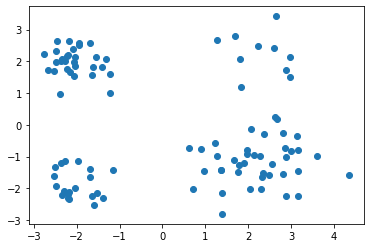

In [38]:
# Test data of shape (100,2)

xs_cluster_test = np.vstack((np.random.normal(loc=(-2,2),scale=np.sqrt(0.2),size=(30,2)),
                            np.random.normal(loc=(-2,-2),scale=np.sqrt(0.2),size=(20,2)),
                            np.random.normal(loc=(2,-1),scale=np.sqrt(0.5),size=(40,2)),
                            np.random.normal(loc=(2,2),scale=np.sqrt(0.5),size=(10,2))))
np.random.shuffle(xs_cluster_test)
plt.scatter(xs_cluster_test[:,0],xs_cluster_test[:,1])


__Task B.3__ Run your $K$-Means algorithm on the test data for $K=2,3,4,5$ clusters and plot the final cluster centers.

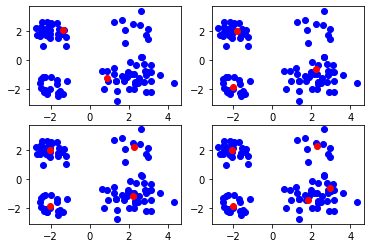

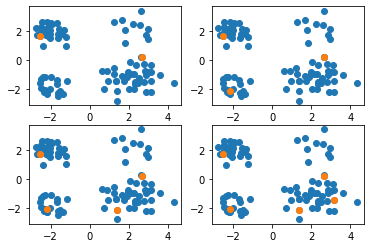

In [39]:
# K = 2
init_centers = [np.array([[0.0,1.0],[0.0,-1.0]]),
                np.array([[0.0,1.0],[1.0,-1.0],[-1.0,-1.0]]),
                np.array([[1.0,1.0],[-1.0,1.0],[1.0,-1.0],[-1.0,-1.0]]),
                np.array([[1.0,1.0],[-1.0,1.0],[1.0,-1.0],[-1.0,-1.0],[1.0,0]])]
for i in range(4):
    plt.subplot(2,2,i+1)
    centers = my_kmeans(xs_cluster_test,init_centers[i],50)
    plt.scatter(xs_cluster_test[:,0],xs_cluster_test[:,1],facecolors='blue')
    plt.scatter(centers[:,0],centers[:,1],facecolors='red')

# Use kmeans_plusplus(xs_cluster_test, K, random_state=0) for initialization
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    centers = kmeans_plusplus(xs_cluster_test,i+2, random_state=0)
    plt.scatter(xs_cluster_test[:,0],xs_cluster_test[:,1])
    plt.scatter(centers[0][:,0],centers[0][:,1])


## Radial Basis Function Network
__Task C.1__ Find $K=100$ cluster centers using $K$-Means.

In [53]:
# This 100x21 numpy array should contain the cluster centers
xs_centers = kmeans_plusplus(xs_train_std,100, random_state=0)[0]
print(xs_centers.shape)

(100, 21)


__Task C.2__ Implement the Gaussian basis functions and transform the data accordingly

In [54]:
def gaussian_transform(x,x_centers):
    N,D = x.shape
    K,D = x_centers.shape
    re = np.array([]).reshape(-1,K)
    a = 1.0/(np.sqrt(2*np.pi*(25**2)))
    for i in range(N):
        r_2 = ((x_centers-x[i,:])**2).sum(axis=1)
        psi = a*np.exp(-r_2/(2*625))
        re = np.vstack((re,psi))
    return re
    pass
xs_train_gauss = gaussian_transform(xs_train_std,xs_centers)

__Task C.3__ Run simple linear regression on the transformed data and evaluate it on the test set

In [56]:
# This should contain the resulting predictions on the validation data set

w_glr = np.linalg.inv(xs_train_gauss.T.dot(xs_train_gauss)).dot(xs_train_gauss.T).dot(ys_train_std)
xs_valid_gauss = gaussian_transform(xs_valid_std,xs_centers)
ys_pred_gauss_valid = xs_valid_gauss.dot(w_glr)

# This should contain the corresponding SMSE
smse_gauss = my_smse(ys_pred_gauss_valid, ys_valid_std, var_ys_train)

__Open task__ Can you improve the performance of the RBF network?

__Task C.4__ Evaluate your final model (either the one from Task C.3 or your improved model from the open task) on the test data

In [18]:
# This should contain the predictions on the test data set
# ys_pred_test = 

# This should contain the resulting SMSE on the test data
# smse_test = 